Test raw map point, line and polygon data retrieval

In [1]:
import pytest
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cv2 as cv
import carla

import carlautil

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000
DELTA = 0.1

In [2]:
map_name = 'Town03'
client = carla.Client(CARLA_HOST, CARLA_PORT)
client.set_timeout(10.0)
world = client.get_world()
# world = client.load_world(map_name)
carla_map = world.get_map()
traffic_manager = client.get_trafficmanager(8000)
carla_topology = carla_map.get_topology()

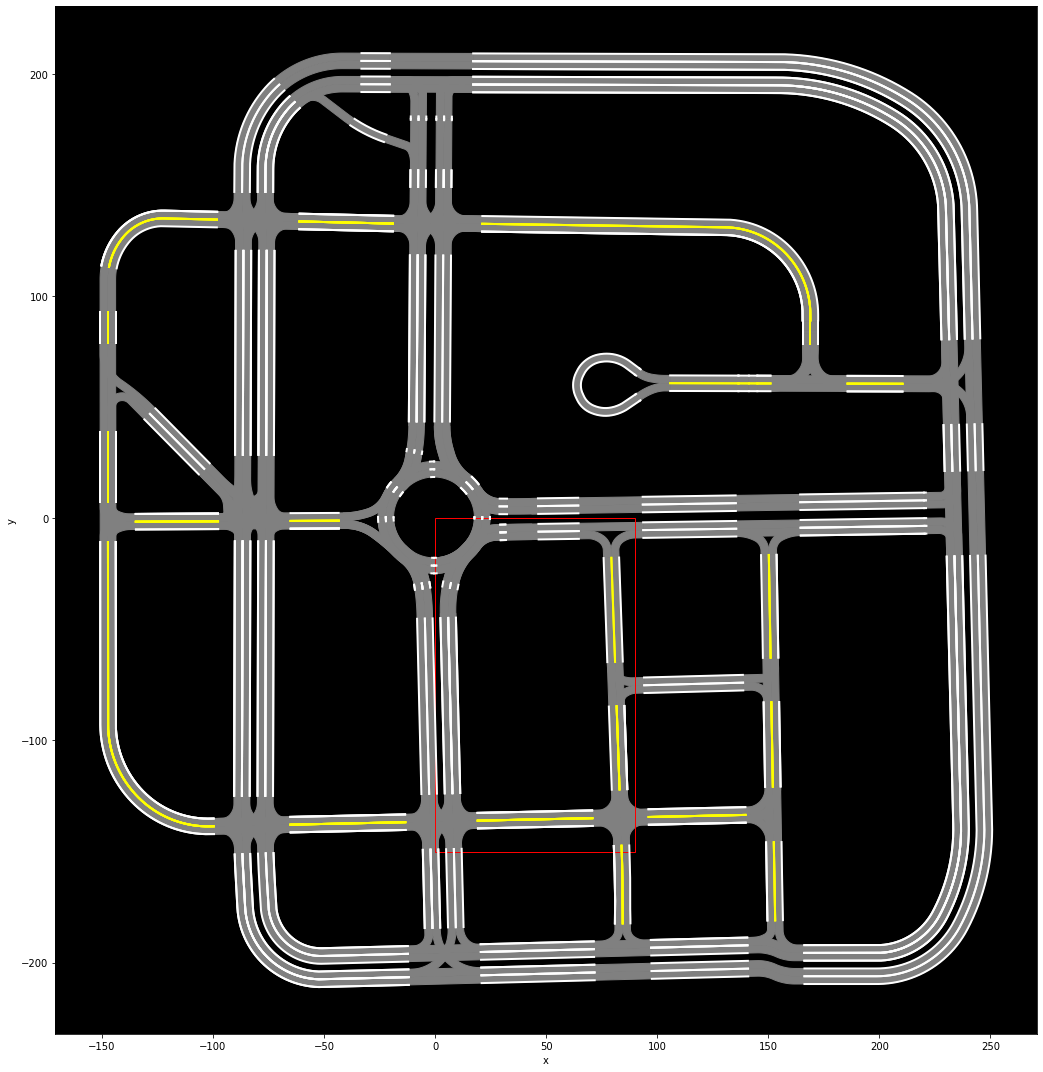

In [22]:
def lateral_shift(transform, shift):
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

def is_yellow_line(waypoint, shift):
    w = carla_map.get_waypoint(lateral_shift(waypoint.transform, shift), project_to_road=False)
    if w is None:
        return False
    return w.lane_id * waypoint.lane_id < 0

road_polygons = []
white_lines   = []
yellow_lines  = []
topology      = [x[0] for x in carla_map.get_topology()]
topology      = sorted(topology, key=lambda w: w.transform.location.z)
precision     = 0.05
for waypoint in topology:
    waypoints = [waypoint]
    nxt = waypoint.next(precision)[0]
    while nxt.road_id == waypoint.road_id:
        waypoints.append(nxt)
        nxt = nxt.next(precision)[0]

    left_marking  = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, -w.lane_width * 0.5) for w in waypoints])
    right_marking = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, w.lane_width * 0.5) for w in waypoints])
    road_polygon = np.concatenate((left_marking, np.flipud(right_marking)), axis=0)

    if len(road_polygon) > 2:
        road_polygons.append(road_polygon)
        if not waypoint.is_intersection:
            sample = waypoints[int(len(waypoints) / 2)]
            if is_yellow_line(sample, -sample.lane_width * 1.1):
                yellow_lines.append(left_marking)
            else:
                white_lines.append(left_marking)
            if is_yellow_line(sample, sample.lane_width * 1.1):
                yellow_lines.append(right_marking)
            else:
                white_lines.append(right_marking)

fig, ax = plt.subplots(figsize=(15,15))

for poly in road_polygons:
    patch = matplotlib.patches.Polygon(poly[:, :2], fill=True, color='grey')
    ax.add_patch(patch)
for line in yellow_lines:
    ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
for line in white_lines:
    ax.plot(line.T[0], line.T[1], c='white', linewidth=2)

x_min  = 0
x_max  = 90
y_min  = -150
y_max  = 0
x_size = x_max - x_min
y_size = y_max - y_min
rect   = matplotlib.patches.Rectangle((x_min, y_min), x_size, y_size, 
                                      linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

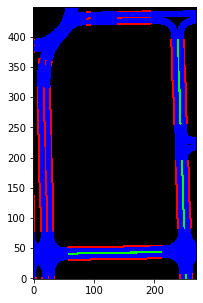

In [26]:
# Get rectangle bitmap from 

pixels_per_m = 3
dim = (int(pixels_per_m * y_size), int(pixels_per_m * x_size), 3)
image = np.zeros(dim)

for polygon in road_polygons:
    rzpoly = ( pixels_per_m*(polygon[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
    cv.fillPoly(image, [rzpoly], (0,0,255))

for line in white_lines:
    rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
    cv.polylines(image, [rzline], False, (255,0,0), thickness=2)

for line in yellow_lines:
    rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
    cv.polylines(image, [rzline], False, (0,255,0), thickness=2)

image = image.astype(np.uint8).swapaxes(0,1)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(image.swapaxes(0,1), origin='lower', interpolation='none')